In [23]:
import os
import numpy as np
from plyfile import PlyData
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

# Analysis

In [2]:
def read_ply_file(file_path):
    plydata = PlyData.read(file_path)
    data = plydata['vertex'].data
    return data

In [3]:
def extract_gaussian_attributes(data):
    attributes = {}
    attributes['positions'] = np.vstack((data['x'], data['y'], data['z'])).T
    attributes['normals'] = np.vstack((data['nx'], data['ny'], data['nz'])).T
    attributes['features_dc'] = np.vstack([data[name] for name in data.dtype.names if 'f_dc' in name]).T
    attributes['features_rest'] = np.vstack([data[name] for name in data.dtype.names if 'f_rest' in name]).T
    attributes['opacity'] = data['opacity']
    attributes['scale'] = np.vstack([data[name] for name in data.dtype.names if 'scale' in name]).T
    attributes['rotation'] = np.vstack([data[name] for name in data.dtype.names if 'rot' in name]).T
    return attributes

In [5]:
filepath = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/time_00000.ply"

In [6]:
gaussian_3dgs = read_ply_file(filepath)
attributes = extract_gaussian_attributes(gaussian_3dgs)

In [7]:
fp2 = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/time_00001.ply"

In [8]:
gaussian_3dgs2 = read_ply_file(fp2)
attributes2 = extract_gaussian_attributes(gaussian_3dgs2)

In [59]:
attributes["features_dc"].min()

-2.1953325

In [55]:
attributes["features_rest"].shape

(198479, 45)

## Pipeline

1. Take the first timestamp Gaussians
2. Take the needed vertices
3. Take all other timestamps, plot values function of mean/overall change w.r.t. positions and colors

In [15]:
vertices_file = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/gaussian_vertices.txt"

with open(vertices_file, "r") as f:
    vertices = f.readlines()
    vertices = list(map(lambda v: int(v.strip()), vertices))

In [67]:
def sh_to_rgb(features_dc):
    # Simple approximation: use the first three SH coefficients as RGB
    rgb = np.clip(features_dc, 0, 1)  # Ensure values are within RGB range
    return (rgb * 255).astype(np.uint8)

def mean_normalized_color(attrs, vertices):
    rgb_colors = sh_to_rgb(attrs['features_dc'][vertices])
    opacity = np.clip(attrs['opacity'][vertices], 0, 1)
    rgba_colors = np.hstack((rgb_colors, (opacity[:, np.newaxis] * 255).astype(np.uint8)))
    return rgba_colors

In [88]:
def compare_gaussians(gaussians_path, vertices):
    #Find filepaths
    files = list(filter(lambda x: x.endswith(".ply"), sorted(os.listdir(gaussians_path))))
    filepaths = list(map(lambda x: os.path.join(gaussians_path, x), files))
    initial_gaussian_path = filepaths[0]
    filepaths = filepaths[1:]
    
    #Initial Gaussian
    initial_attributes = extract_gaussian_attributes(read_ply_file(initial_gaussian_path))
    
    results = {
        "positions": [],
        "colors": []
    }
    
    for fp in tqdm(filepaths):
        current_attributes = extract_gaussian_attributes(read_ply_file(fp))
        
        #Positions
        results["positions"].append(
            np.linalg.norm(initial_attributes["positions"][vertices] - current_attributes["positions"][vertices],
                           axis=1)
        )
        results["colors"].append(
            np.linalg.norm(
                mean_normalized_color(initial_attributes, vertices) - 
                mean_normalized_color(current_attributes, vertices),
                axis=1
            )
        )
    
    results["positions"] = np.vstack(results["positions"])
    results["colors"] = np.vstack(results["colors"])
    
    return results

In [81]:
gaussian_paths = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp"

In [82]:
results = compare_gaussians(gaussian_paths, vertices)

100%|██████████████████████████████████████████████████████████████| 317/317 [00:17<00:00, 17.95it/s]


In [83]:
results["colors"].mean(axis=1).shape

(317,)

In [84]:
def plot_value_function(array, fig=None, ax=None, label="positions", color="b"):
    """
    array: [n x d]
    """
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    mean_changes = array.mean(axis=1)
    std_changes = array.std(axis=1)
    
    frames = range(1, array.shape[0] + 1)
    
    # Plot mean changes
    ax.plot(frames, mean_changes, label=f"Mean {label} changes over {array.shape[0]} points", color=color)
    
    frames_to_look_at = [30, 46, 52, 98, 139, 177]
    for frame in frames_to_look_at:
        ax.axvline(frame, color="r")
    
    # Plot std as error bands
    ax.fill_between(frames, mean_changes - std_changes, mean_changes + std_changes, color='b', alpha=0.2, label="±1 Std Dev")
    
    ax.set_xlabel("Frame")
    ax.set_ylabel("Changes")
    ax.legend()
    
    return fig, ax

In [87]:
results["colors"].shape

(317, 674)

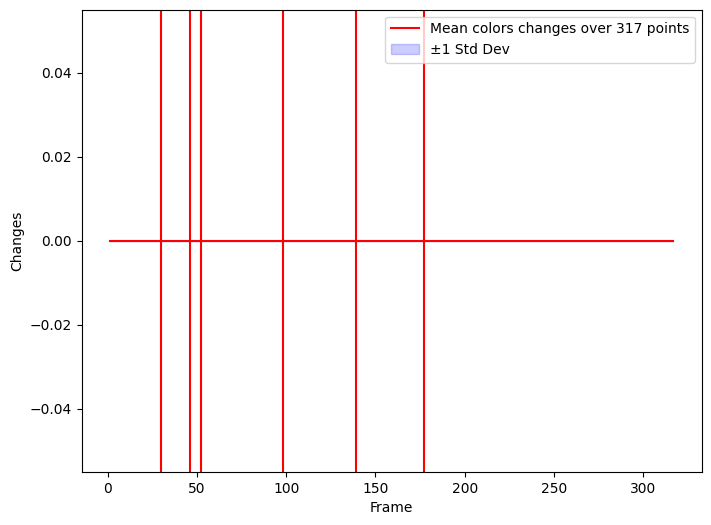

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))

#fig, ax = plot_value_function(results["positions"], fig, ax, "positions", "b")
fig, ax = plot_value_function(results["colors"], fig, ax, "colors", "r")
plt.show()

### Colors

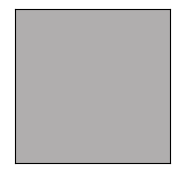

In [62]:
# Load data
filepath = '/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/time_00000.ply'
gaussian_3dgs = read_ply_file(filepath)
attributes = extract_gaussian_attributes(gaussian_3dgs)

# Convert SH to RGB
rgb_colors = sh_to_rgb(attributes['features_dc'])

# Normalize opacity to the range [0, 1]
opacity = np.clip(attributes['opacity'], 0, 1)

# Combine RGB and opacity into RGBA
rgba_colors = np.hstack((rgb_colors, (opacity[:, np.newaxis] * 255).astype(np.uint8)))

# Calculate the mean RGBA color
mean_rgba_color = rgba_colors.mean(axis=0).astype(np.uint8)

# Plot the mean color
mean_color_normalized = mean_rgba_color / 255  # Normalize to [0, 1] for plotting
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_facecolor(mean_color_normalized)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Example usage: visualize the first few RGBA colors (for verification)
#print("RGBA Colors:", rgba_colors[:10])
#print("Mean RGBA Color:", mean_rgba_color)

In [63]:
mean_color_normalized

array([0.25490196, 0.24313725, 0.24313725, 0.41568627])

In [66]:
rgba_colors.shape

(198479, 4)

In [89]:
mean_normalized_color(attributes, vertices)

array([[  0,   0,   0,   0],
       [236, 255, 255,   0],
       [  9,  39,  68,   0],
       ...,
       [255, 255, 255, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0,  20]], dtype=uint8)

In [91]:
f = "/vol/isy-rl/prj-rgbd2mesh/dtrofimov/4DGaussians/output/home-inter/gaussian_pertimestamp/time_00150.ply"
attributes_150 = extract_gaussian_attributes(read_ply_file(f))

In [90]:
mean_normalized_color(attributes2, vertices)

array([[  0,   0,   0,   0],
       [236, 255, 255,   0],
       [  9,  39,  68,   0],
       ...,
       [255, 255, 255, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0,  20]], dtype=uint8)

In [94]:
(mean_normalized_color(attributes2, vertices) - mean_normalized_color(attributes_150, vertices)).mean()

0.0